In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from scipy.stats import maxwell

import os, sys, inspect
current_dir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
parent_dir = os.path.dirname(current_dir)
sys.path.insert(0, parent_dir) 

import algorithms as a
import force_functions as f

In [2]:
np.random.seed(1)

In [3]:
N = 128
L = 30.
lam = 0.1931833275037836

In [4]:
def init(N, L, T):
    
    #positions = list(np.arange(-L/2., L/2., 1.5))
    #r0 = np.array(np.meshgrid(positions, positions, positions)).T.reshape(-1,3)
    r0 = np.random.uniform(-L/2, L/2, size=(N,3))
    p0 = maxwell.rvs(loc=0, scale=T, size=(N,3)) / np.sqrt(T)
    
    return r0, p0

In [5]:
def calc_energy(r, p, sigma, periodic=None):
    if periodic is None:
        periodic = {'PBC': False,
                    'box_size': 0,
                    'closed': False}

    idx = np.arange(len(r))
    pairs = np.meshgrid(idx, idx)
    separations = r[pairs[0]] - r[pairs[1]]

    if periodic['PBC']:
        separations[np.where(separations > periodic['box_size'] / 2.)] -= periodic['box_size']
        separations[np.where(separations < -periodic['box_size'] / 2.)] += periodic['box_size']

    distances = np.triu(np.linalg.norm(separations, axis=-1))

    V = (4 * np.power(sigma / distances, 12) - 4 * np.power(sigma / distances, 6))
    V[np.isnan(V)] = 0.
    V = V.sum()
    
    T = .5 * np.linalg.norm(p)**2
    
    return V + T

In [6]:
r0, p0 = init(N=128, L=30., T=1.5)

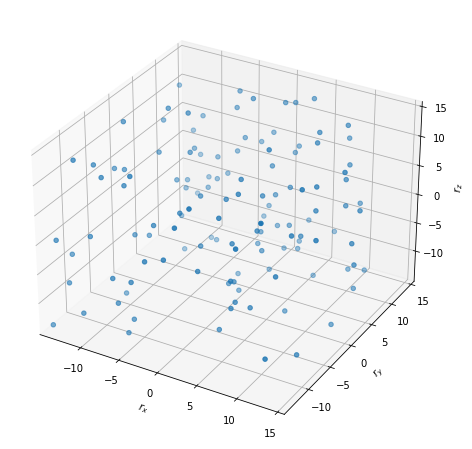

In [7]:
fig0 = plt.figure(figsize=(12,8));
ax0 = fig0.add_subplot(111, projection='3d')
ax0.scatter(r0[:,0], r0[:,1], r0[:,2])
ax0.set_xlabel(r'$r_x$')
ax0.set_ylabel(r'$r_y$')
ax0.set_zlabel(r'$r_z$')
ax0.set_xlim(-L/2+.2,L/2+.2)
ax0.set_ylim(-L/2+.2,L/2+.2)
ax0.set_zlim(-L/2+.2,L/2+.2)
#plt.savefig('./figures/init_pos.png', dpi=300, bbox_inches='tight')
plt.show()

In [12]:
for k in range(3):
    

0
1
2


In [8]:
R, P, t = a.BABAB_Ndim(r0, p0, t_max, dt0, f.LJ_force, lam, thermal_noise=False, maxwell_noise=False,
                       periodic={'PBC': True, 'box_size': L, 'closed': False})

  0%|          | 0/999 [00:00<?, ?it/s]/Users/erichter/Documents/Uni/SS21/MolecularSimulations/Assignments/molecular_simulations/force_functions.py:173: RuntimeWarning: divide by zero encountered in true_divide
  f = (48 * np.power(sigma, 12) / np.power(distances, 13) - 24 * np.power(sigma, 6) / np.power(distances, 7)) / distances
/Users/erichter/Documents/Uni/SS21/MolecularSimulations/Assignments/molecular_simulations/force_functions.py:173: RuntimeWarning: invalid value encountered in subtract
  f = (48 * np.power(sigma, 12) / np.power(distances, 13) - 24 * np.power(sigma, 6) / np.power(distances, 7)) / distances
100%|██████████| 999/999 [00:06<00:00, 166.42it/s]


In [9]:
E = np.zeros(len(t))
for i in range(len(t)):
    E[i] = calc_energy(R[i], P[i], sigma=2.5**(1/3.), periodic={'PBC': True, 'box_size': L, 'closed': False})

<ipython-input-5-c07f12e42591>:17: RuntimeWarning: divide by zero encountered in true_divide
  V = (4 * np.power(sigma / distances, 12) - 4 * np.power(sigma / distances, 6))
<ipython-input-5-c07f12e42591>:17: RuntimeWarning: invalid value encountered in subtract
  V = (4 * np.power(sigma / distances, 12) - 4 * np.power(sigma / distances, 6))


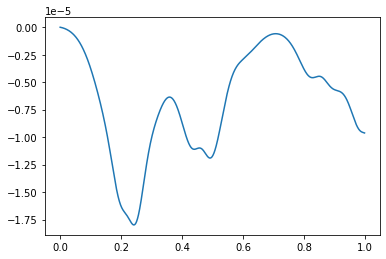

In [10]:
plt.plot(t, E-E[0])